In [42]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from datetime import datetime
from dateutil.relativedelta import relativedelta

emphasize = 'Rocky Linux'
figx = 16.18
figy = 10
plotstyle = 'ggplot'
startdate = datetime.today() - relativedelta(years=1)
startdatelong = '2020-12-08'
datadir = 'data/'
workdir = 'out/'

def thousands(x, pos):
    return '{:,.0f}k'.format(x*1e-3)

def millions(x, pos):
    return '{:,.1f}M'.format(x*1e-6)

distros = ['AlmaLinux', 'CentOS Linux', 'CentOS Stream', 'Oracle Linux Server', 'Red Hat Enterprise Linux', 'Rocky Linux']
dh_distros = ['AlmaLinux', 'CentOS Linux', 'Oracle Linux Server', 'Red Hat Enterprise Linux', 'Rocky Linux']
colors = {'AlmaLinux':'#4AC1FA', 'CentOS Linux':'#E9A942', 'CentOS Stream':'#9A5689', 'Oracle Linux Server':'#BE503B', 'Red Hat Enterprise Linux':'#E2321D', 'Rocky Linux':'#48B585'}
labels = {'AlmaLinux':'AlmaLinux', 'CentOS Linux':'CentOS Legacy', 'CentOS Stream':'CentOS Stream', 'Oracle Linux Server':'Oracle', 'Red Hat Enterprise Linux':'RHEL', 'Rocky Linux':'Rocky Linux'}

In [43]:
# EPEL data import and preprocessing
epel_dataframe = pd.read_csv(datadir + 'epel.csv', parse_dates=['week_end','week_start'])

# Remove egregious data errors:

# Half a million age group 3 RHEL boxes blip in and out of existence here:
epel_dataframe = epel_dataframe.drop(index=462163)

# All distros drop to near nothing at these dates:
epel_dataframe = epel_dataframe.drop(epel_dataframe[epel_dataframe['week_end'] == '2023-05-07'].index)
epel_dataframe = epel_dataframe.drop(epel_dataframe[epel_dataframe['week_end'] == '2023-05-14'].index)
epel_dataframe = epel_dataframe.drop(epel_dataframe[epel_dataframe['week_end'] == '2023-10-29'].index)
epel_dataframe = epel_dataframe.drop(epel_dataframe[epel_dataframe['week_end'] == '2023-11-05'].index)

# DockerHub data import and preprocessing
df = pd.read_csv(datadir + 'dockerhub.csv', index_col=0, parse_dates=['Date']).diff().iloc[1:]
dh_dataframe = pd.DataFrame(index=df.index, columns=dh_distros)
dh_dataframe['AlmaLinux'] = df['library/almalinux'] + \
                            df['almalinux/8-base'] + \
                            df['almalinux/8-init'] + \
                            df['almalinux/8-micro'] + \
                            df['almalinux/8-minimal'] + \
                            df['almalinux/9-base'] + \
                            df['almalinux/9-init'] + \
                            df['almalinux/9-micro'] + \
                            df['almalinux/9-minimal'] + \
                            df['almalinux/almalinux'] + \
                            df['almalinux/amd64'] + \
                            df['almalinux/arm64v8'] + \
                            df['almalinux/i386'] + \
                            df['almalinux/ppc64le'] + \
                            df['almalinux/s390x']
dh_dataframe['CentOS Linux'] = df['library/centos']
dh_dataframe['Oracle Linux Server'] = df['library/oraclelinux']
dh_dataframe['Red Hat Enterprise Linux'] = df['redhat/ubi8'] + \
                                           df['redhat/ubi8-init'] + \
                                           df['redhat/ubi8-micro'] + \
                                           df['redhat/ubi8-minimal'] + \
                                           df['redhat/ubi9'] + \
                                           df['redhat/ubi9-init'] + \
                                           df['redhat/ubi9-micro'] + \
                                           df['redhat/ubi9-minimal']
dh_dataframe['Rocky Linux'] = df['library/rockylinux'] + \
                              df['rockylinux/rockylinux']

/var/folders/54/zdqwn78j1cn7yvymyvv75shw0000gn/T/ipykernel_4132/4201003852.py:2: DtypeWarning: Columns (3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  epel_dataframe = pd.read_csv(datadir + 'epel.csv', parse_dates=['week_end','week_start'])


/var/folders/54/zdqwn78j1cn7yvymyvv75shw0000gn/T/ipykernel_4132/450517189.py:4: FutureWarning: The provided callable <function sum at 0x10409cd60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_name', fill_value=0, aggfunc=np.sum)


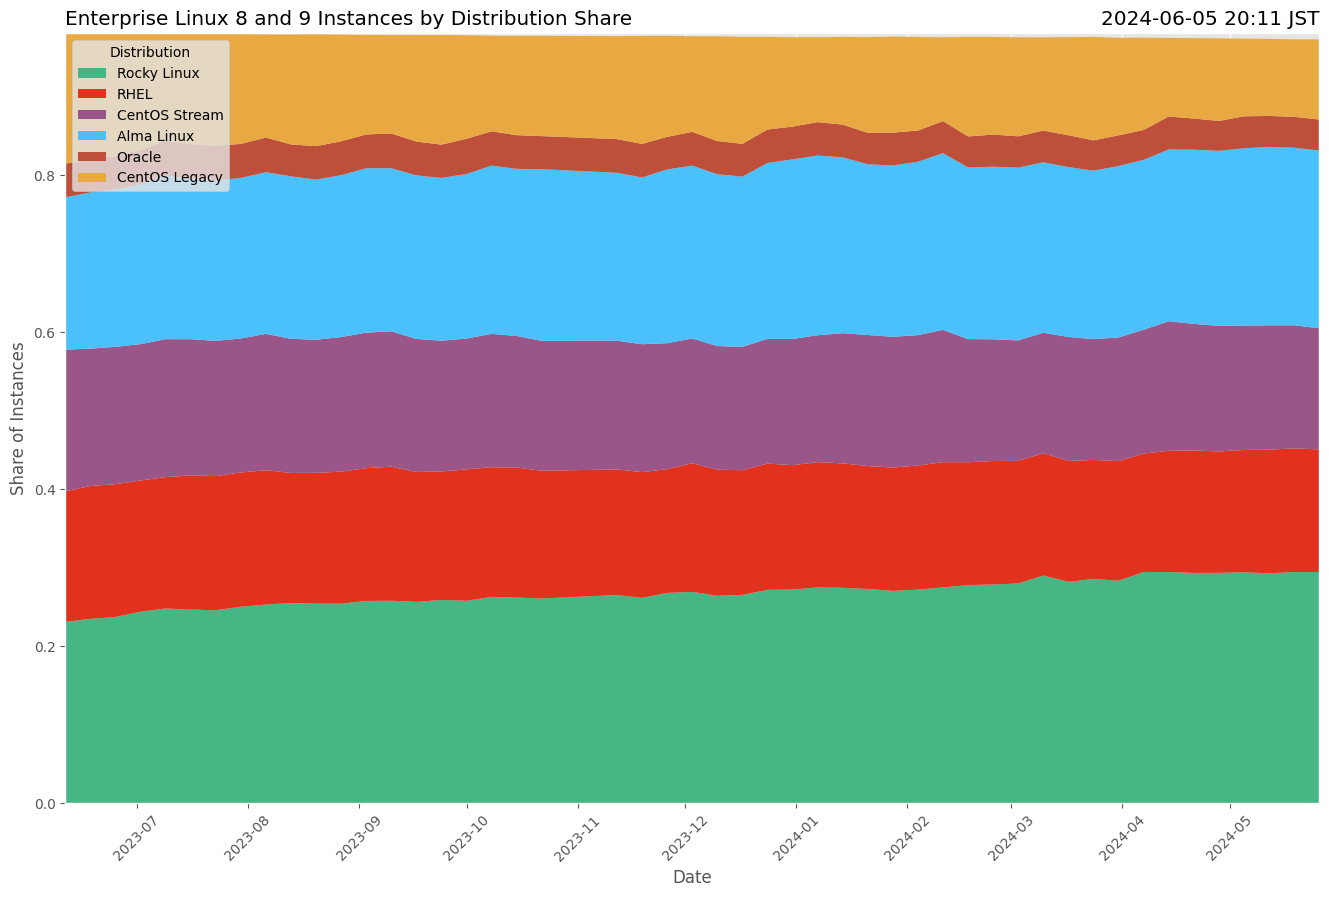

In [44]:
# Enterprise Linux Instances by Distribution Share
df = epel_dataframe
df = df[(df['repo_tag'].isin(['epel-8', 'epel-9'])) & (df['week_end'] > startdate)]
pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_name', fill_value=0, aggfunc=np.sum)

pt['total'] = pt.sum(numeric_only = True, axis = 1)

plt.style.use(plotstyle)
fig = plt.figure(figsize=(figx, figy))
ax = fig.add_subplot()
ax.stackplot(pt.index, pt['Rocky Linux']/pt['total'], pt['Red Hat Enterprise Linux']/pt['total'], pt['CentOS Stream']/pt['total'], pt['AlmaLinux']/pt['total'], pt['Oracle Linux Server']/pt['total'], pt['CentOS Linux']/pt['total'], \
             labels=['Rocky Linux', 'RHEL', 'CentOS Stream', 'Alma Linux', 'Oracle', 'CentOS Legacy'], \
             colors=['#48B585', '#E2321D', '#9A5689', '#4AC1FA', '#BE503B', '#E9A942'])
xmajorrule = mdates.RRuleLocator(mdates.rrulewrapper(mdates.MONTHLY))

plt.title('Enterprise Linux 8 and 9 Instances by Distribution Share', loc='left')
plt.title(datetime.now().astimezone().strftime("%Y-%m-%d %H:%M %Z"), loc='right')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Share of Instances')
plt.legend(title='Distribution', loc='upper left')
plt.margins(0, tight=True)
plt.savefig(workdir + 'el89_by_distro_total_share_area.png', bbox_inches='tight')
plt.savefig(workdir + 'el89_by_distro_total_share_area.svg', bbox_inches='tight')

/var/folders/54/zdqwn78j1cn7yvymyvv75shw0000gn/T/ipykernel_4132/679227292.py:4: FutureWarning: The provided callable <function sum at 0x10409cd60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_name', fill_value=0, aggfunc=np.sum)


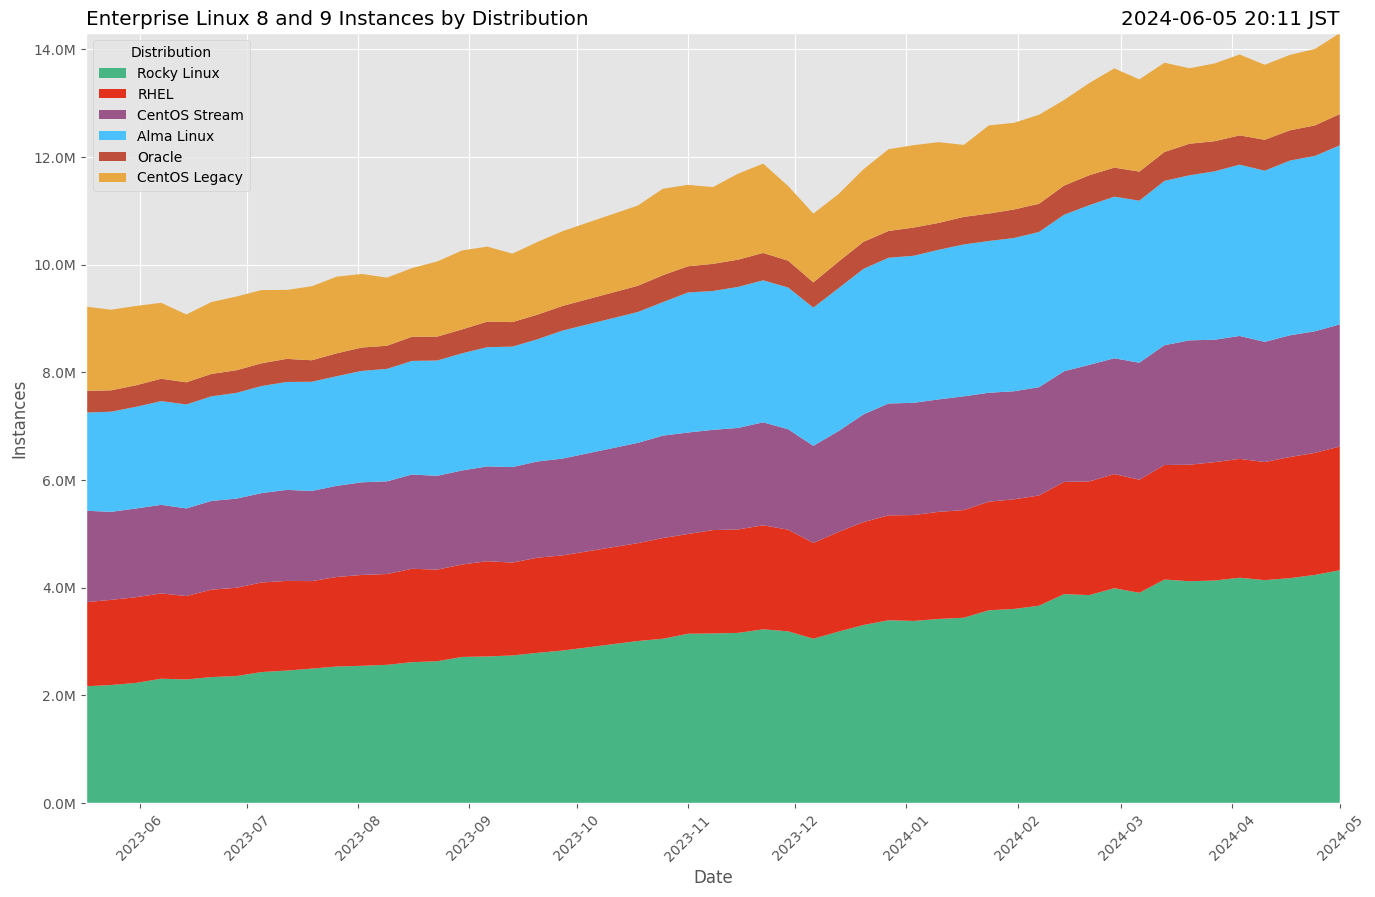

In [45]:
# Enterprise Linux Instances by Distribution 
df = epel_dataframe
df = df[(df['repo_tag'].isin(['epel-8', 'epel-9'])) & (df['week_end'] > startdate)]
pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_name', fill_value=0, aggfunc=np.sum)

plt.style.use(plotstyle)
fig = plt.figure(figsize=(figx, figy))
ax = fig.add_subplot()
ax.stackplot(pt.index, pt['Rocky Linux'], pt['Red Hat Enterprise Linux'], pt['CentOS Stream'], pt['AlmaLinux'], pt['Oracle Linux Server'], pt['CentOS Linux'], labels=['Rocky Linux', 'RHEL', 'CentOS Stream', 'Alma Linux', 'Oracle', 'CentOS Legacy'], colors=['#48B585', '#E2321D', '#9A5689', '#4AC1FA', '#BE503B', '#E9A942'])
xmajorrule = mdates.RRuleLocator(mdates.rrulewrapper(mdates.MONTHLY))
ax.xaxis.set_major_locator(xmajorrule)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(millions))
plt.title('Enterprise Linux 8 and 9 Instances by Distribution', loc='left')
plt.title(datetime.now().astimezone().strftime("%Y-%m-%d %H:%M %Z"), loc='right')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Instances')
plt.legend(title='Distribution', loc='upper left')
plt.margins(0, tight=True)
plt.savefig(workdir + 'el89_by_distro_total_area.png', bbox_inches='tight')
plt.savefig(workdir + 'el89_by_distro_total_area.svg', bbox_inches='tight')

/var/folders/54/zdqwn78j1cn7yvymyvv75shw0000gn/T/ipykernel_4132/665330966.py:4: FutureWarning: The provided callable <function sum at 0x10409cd60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_name', fill_value=0, aggfunc=np.sum)


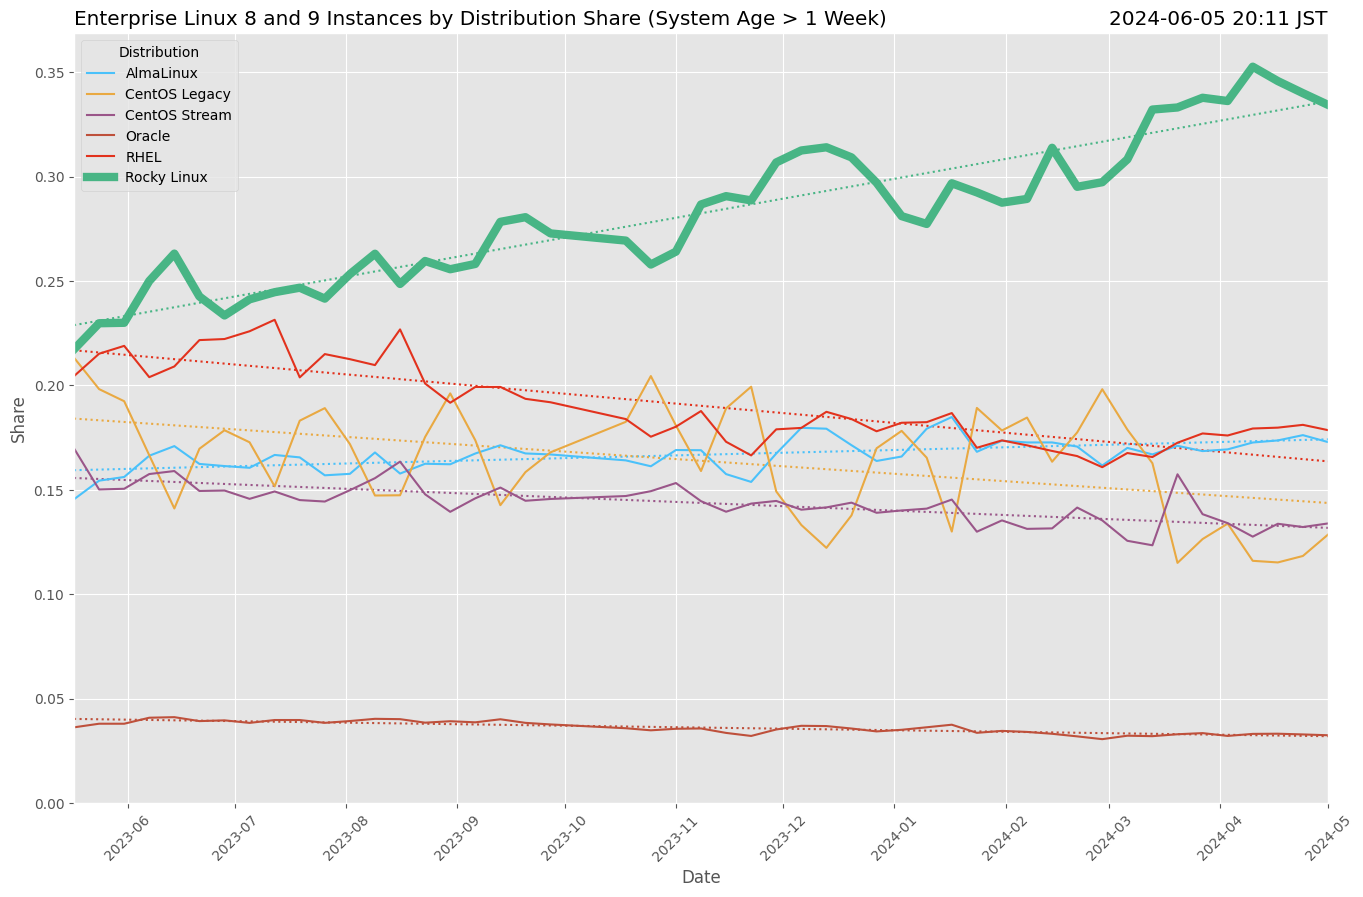

In [46]:
# Enterprise Linux Instances by Distribution Share
df = epel_dataframe
df = df[(df['repo_tag'].isin(['epel-8', 'epel-9'])) & (df['sys_age'] > 1) & (df['week_end'] > startdate)]
pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_name', fill_value=0, aggfunc=np.sum)

pt['total'] = pt.sum(numeric_only = True, axis = 1)

plt.style.use(plotstyle)
fig = plt.figure(figsize=(figx, figy))
ax = fig.add_subplot()

for distro in distros:
  x = mdates.date2num(pt.index)
  z = np.polyfit(x, pt[distro]/pt['total'], 1)
  p = np.poly1d(z)
  xx = np.linspace(x.min(), x.max(), 100)
  dd = mdates.num2date(xx)
  ax.plot(dd, p(xx), ':', color=colors[distro])

for distro in distros:
  if distro == emphasize:
    ax.plot(pt[distro]/pt['total'], label=labels[distro], color=colors[distro], linewidth=6)
  else:
    ax.plot(pt[distro]/pt['total'], label=labels[distro], color=colors[distro])

xmajorrule = mdates.RRuleLocator(mdates.rrulewrapper(mdates.MONTHLY))
ax.xaxis.set_major_locator(xmajorrule)
ax.set_ylim(bottom=0)
plt.title('Enterprise Linux 8 and 9 Instances by Distribution Share (System Age > 1 Week)', loc='left')
plt.title(datetime.now().astimezone().strftime("%Y-%m-%d %H:%M %Z"), loc='right')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Share')
plt.legend(title='Distribution')
plt.margins(0, tight=True)
plt.savefig(workdir + 'el_by_distro_share_line.png', bbox_inches='tight')
plt.savefig(workdir + 'el_by_distro_share_line.svg', bbox_inches='tight')

/var/folders/54/zdqwn78j1cn7yvymyvv75shw0000gn/T/ipykernel_4132/3340861645.py:4: FutureWarning: The provided callable <function sum at 0x10409cd60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_name', fill_value=0, aggfunc=np.sum)


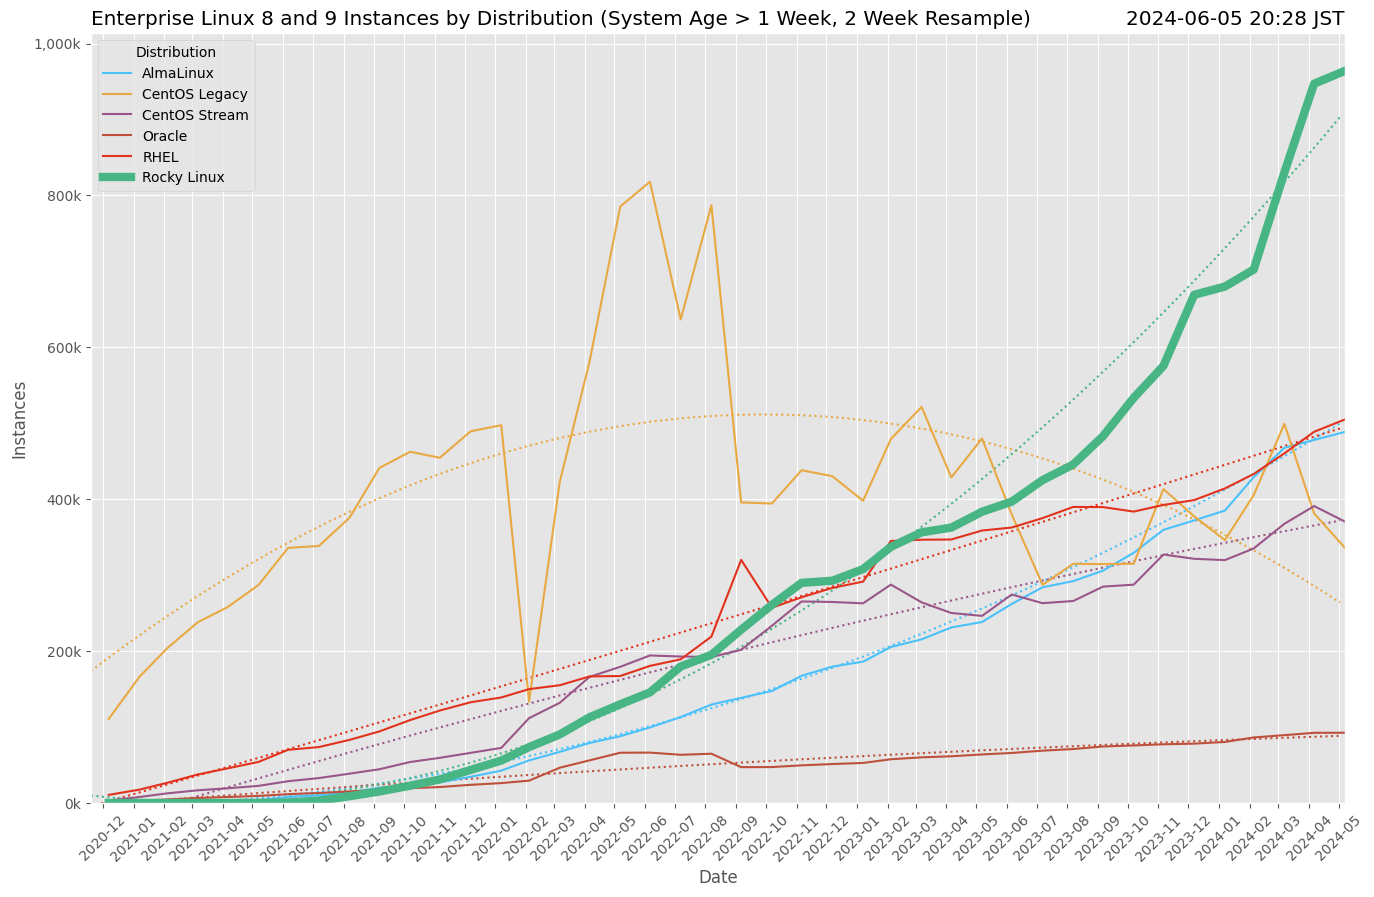

In [67]:
# Enterprise Linux Instances by Distribution
df = epel_dataframe
df = df[(df['repo_tag'].isin(['epel-8', 'epel-9'])) & (df['sys_age'] > 1) & (df['week_end'] > '2020-12-08')]
pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_name', fill_value=0, aggfunc=np.sum)

plt.style.use(plotstyle)
fig = plt.figure(figsize=(figx, figy))
ax = fig.add_subplot()

for distro in distros:
  x = mdates.date2num(pt.index)
  z = np.polyfit(x, pt[distro], 2)
  p = np.poly1d(z)
  xx = np.linspace(x.min(), x.max(), 100)
  dd = mdates.num2date(xx)
  ax.plot(dd, p(xx), ':', color=colors[distro])

pt = pt.resample('2W').mean()

for distro in distros:
  if distro == emphasize:
    ax.plot(pt[distro], label=labels[distro], color=colors[distro], linewidth=6)
  else:
    ax.plot(pt[distro], label=labels[distro], color=colors[distro])

# TODO: labels
#idx = np.round(np.linspace(0, len(pt.index) - 1, 12)).astype(int)
#for x,y in zip(pt.index,pt[emphasize]):
#    label = "{:}".format(y)
#    plt.annotate(label, # this is the text
#                 (x,y), # these are the coordinates to position the label
#                 textcoords="offset points", # how to position the text
#                 xytext=(0,10), # distance from text to points (x,y)
#                 ha='center') # horizontal alignment can be left, right or center

xmajorrule = mdates.RRuleLocator(mdates.rrulewrapper(mdates.MONTHLY))
ax.xaxis.set_major_locator(xmajorrule)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands))
ax.set_ylim(bottom=0)
plt.title('Enterprise Linux 8 and 9 Instances by Distribution (System Age > 1 Week, 2 Week Resample)', loc='left')
plt.title(datetime.now().astimezone().strftime("%Y-%m-%d %H:%M %Z"), loc='right')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Instances')
plt.legend(title='Distribution')
plt.margins(0, tight=True)
plt.savefig(workdir + 'el_by_distro_longterm_line.png', bbox_inches='tight')
plt.savefig(workdir + 'el_by_distro_longterm_line.svg', bbox_inches='tight')

/var/folders/54/zdqwn78j1cn7yvymyvv75shw0000gn/T/ipykernel_4132/3018479882.py:4: FutureWarning: The provided callable <function sum at 0x10409cd60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_name', fill_value=0, aggfunc=np.sum)


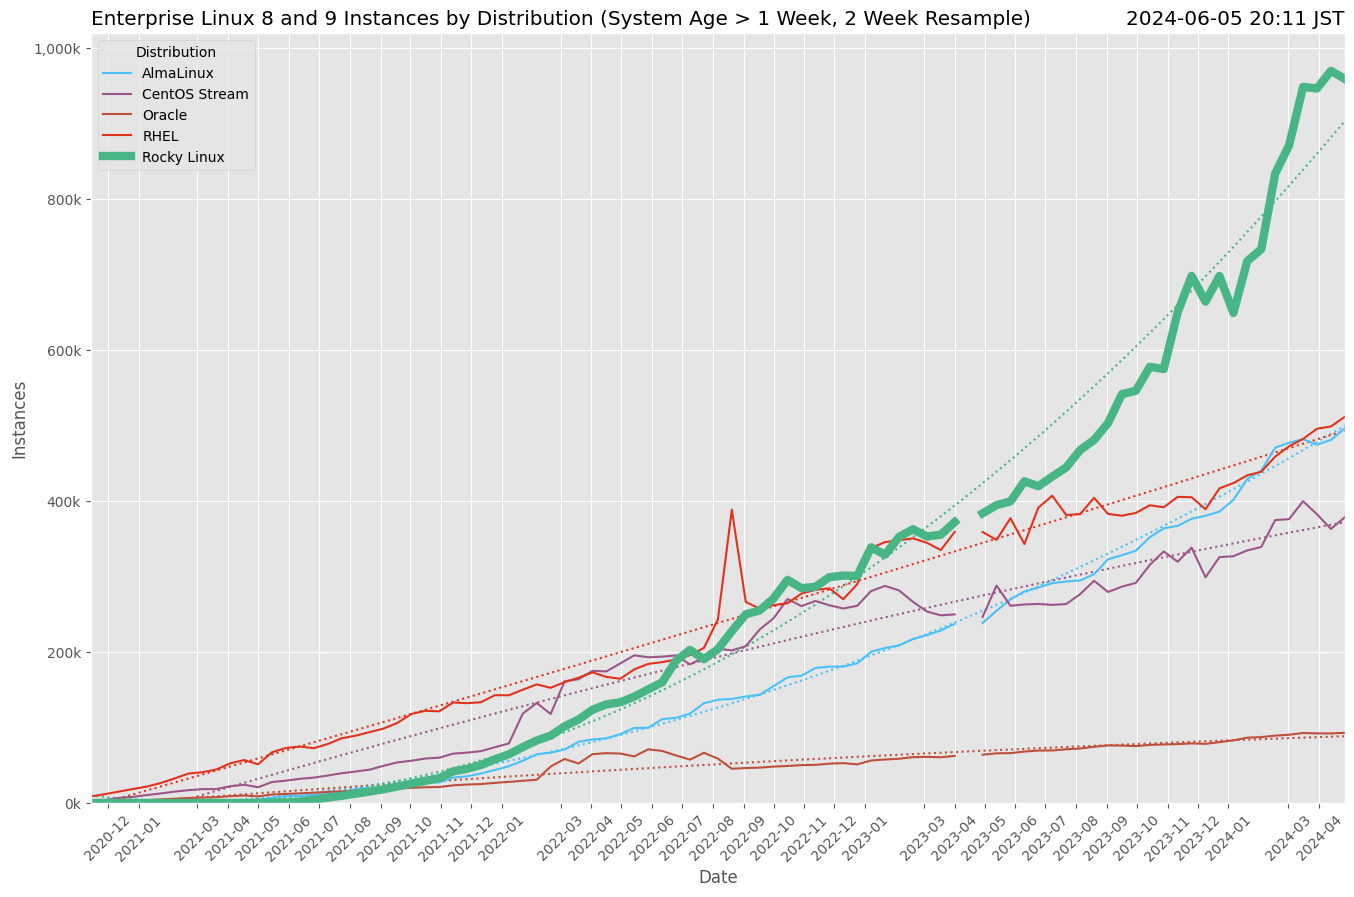

In [48]:
# Enterprise Linux Instances by Distribution (without Legacy CentOS)
df = epel_dataframe
df = df[(df['repo_tag'].isin(['epel-8', 'epel-9'])) & (df['sys_age'] > 1) & (df['week_end'] > '2020-12-08')]
pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_name', fill_value=0, aggfunc=np.sum)

plt.style.use(plotstyle)
fig = plt.figure(figsize=(figx, figy))
ax = fig.add_subplot()

for distro in distros:
  if distro == 'CentOS Linux':
    continue
  x = mdates.date2num(pt.index)
  z = np.polyfit(x, pt[distro], 2)
  p = np.poly1d(z)
  xx = np.linspace(x.min(), x.max(), 100)
  dd = mdates.num2date(xx)
  ax.plot(dd, p(xx), ':', color=colors[distro])

pt = pt.resample('2W').mean()

for distro in distros:
  if distro == 'CentOS Linux':
    continue
  if distro == emphasize:
    ax.plot(pt[distro], label=labels[distro], color=colors[distro], linewidth=6)
  else:
    ax.plot(pt[distro], label=labels[distro], color=colors[distro])

# TODO: labels
#idx = np.round(np.linspace(0, len(pt.index) - 1, 12)).astype(int)
#for x,y in zip(pt.index,pt[emphasize]):
#    label = "{:}".format(y)
#    plt.annotate(label, # this is the text
#                 (x,y), # these are the coordinates to position the label
#                 textcoords="offset points", # how to position the text
#                 xytext=(0,10), # distance from text to points (x,y)
#                 ha='center') # horizontal alignment can be left, right or center

xmajorrule = mdates.RRuleLocator(mdates.rrulewrapper(mdates.MONTHLY))
ax.xaxis.set_major_locator(xmajorrule)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands))
ax.set_ylim(bottom=0)
plt.title('Enterprise Linux 8 and 9 Instances by Distribution (System Age > 1 Week, 2 Week Resample)', loc='left')
plt.title(datetime.now().astimezone().strftime("%Y-%m-%d %H:%M %Z"), loc='right')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Instances')
plt.legend(title='Distribution')
plt.margins(0, tight=True)
plt.savefig(workdir + 'el_by_distro_longterm_line_nocentos.png', bbox_inches='tight')
plt.savefig(workdir + 'el_by_distro_longterm_line_nocentos.svg', bbox_inches='tight')

/var/folders/54/zdqwn78j1cn7yvymyvv75shw0000gn/T/ipykernel_4132/3413539108.py:4: FutureWarning: The provided callable <function sum at 0x10409cd60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_name', fill_value=0, aggfunc=np.sum)


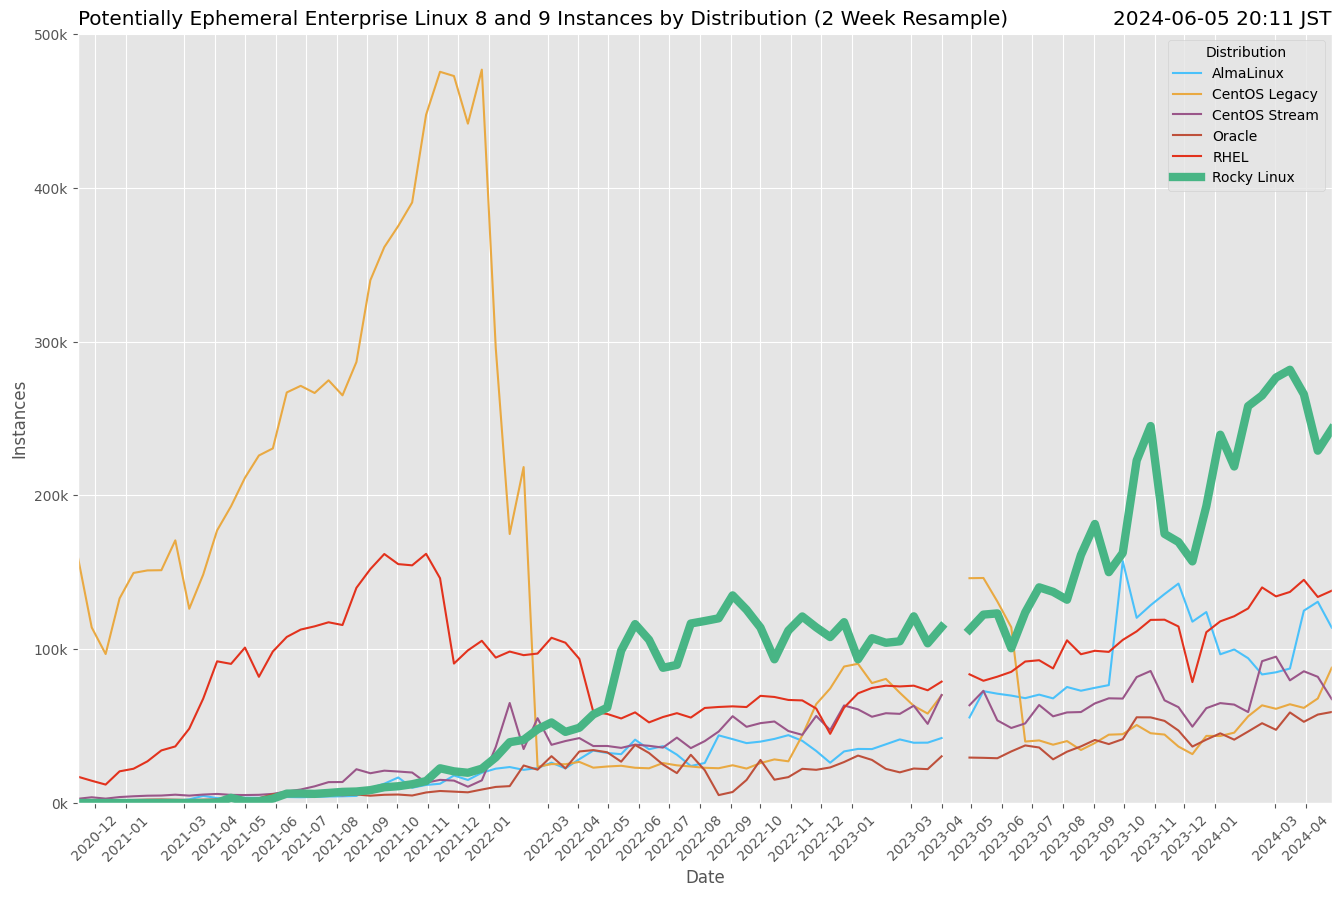

In [49]:
# Enterprise Linux Instances by Distribution
df = epel_dataframe
df = df[(df['repo_tag'].isin(['epel-8', 'epel-9'])) & (df['sys_age'] == 1) & (df['week_end'] > '2020-12-08')]
pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_name', fill_value=0, aggfunc=np.sum)

plt.style.use(plotstyle)
fig = plt.figure(figsize=(figx, figy))
ax = fig.add_subplot()

pt = pt.resample('2W').mean()

for distro in distros:
  if distro == emphasize:
    ax.plot(pt[distro], label=labels[distro], color=colors[distro], linewidth=6)
  else:
    ax.plot(pt[distro], label=labels[distro], color=colors[distro])

xmajorrule = mdates.RRuleLocator(mdates.rrulewrapper(mdates.MONTHLY))
ax.xaxis.set_major_locator(xmajorrule)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands))
ax.set_ylim(bottom=0)
plt.title('Potentially Ephemeral Enterprise Linux 8 and 9 Instances by Distribution (2 Week Resample)', loc='left')
plt.title(datetime.now().astimezone().strftime("%Y-%m-%d %H:%M %Z"), loc='right')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Instances')
plt.legend(title='Distribution')
plt.margins(0, tight=True)
plt.savefig(workdir + 'el_by_distro_ephemeral_longterm_line.png', bbox_inches='tight')
plt.savefig(workdir + 'el_by_distro_ephemeral_longterm_line.svg', bbox_inches='tight')

/var/folders/54/zdqwn78j1cn7yvymyvv75shw0000gn/T/ipykernel_4132/736215127.py:4: FutureWarning: The provided callable <function sum at 0x10409cd60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_name', fill_value=0, aggfunc=np.sum)


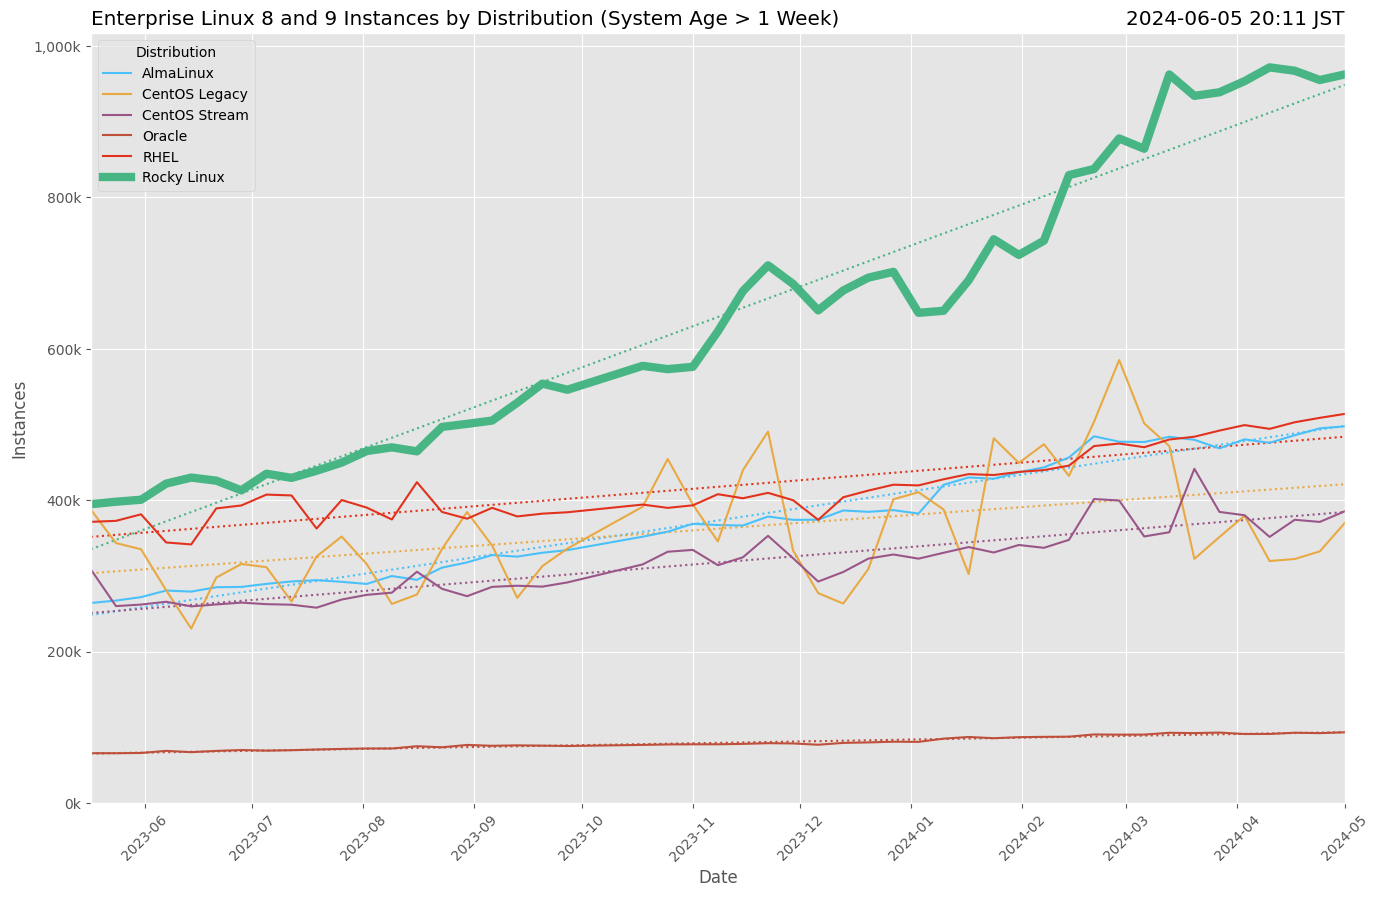

In [50]:
# Enterprise Linux Instances by Distribution
df = epel_dataframe
df = df[(df['repo_tag'].isin(['epel-8', 'epel-9'])) & (df['sys_age'] > 1) & (df['week_end'] > startdate)]
pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_name', fill_value=0, aggfunc=np.sum)

# TODO: Monthly averages?
# pt = pt.resample('M').mean()

plt.style.use(plotstyle)
fig = plt.figure(figsize=(figx, figy))
ax = fig.add_subplot()

for distro in distros:
  x = mdates.date2num(pt.index)
  z = np.polyfit(x, pt[distro], 1)
  p = np.poly1d(z)
  xx = np.linspace(x.min(), x.max(), 100)
  dd = mdates.num2date(xx)
  ax.plot(dd, p(xx), ':', color=colors[distro])

for distro in distros:
  if distro == emphasize:
    ax.plot(pt[distro], label=labels[distro], color=colors[distro], linewidth=6)
  else:
    ax.plot(pt[distro], label=labels[distro], color=colors[distro])

# TODO: labels
#idx = np.round(np.linspace(0, len(pt.index) - 1, 12)).astype(int)
#for x,y in zip(pt.index,pt[emphasize]):
#    label = "{:}".format(y)
#    plt.annotate(label, # this is the text
#                 (x,y), # these are the coordinates to position the label
#                 textcoords="offset points", # how to position the text
#                 xytext=(0,10), # distance from text to points (x,y)
#                 ha='center') # horizontal alignment can be left, right or center

xmajorrule = mdates.RRuleLocator(mdates.rrulewrapper(mdates.MONTHLY))
ax.xaxis.set_major_locator(xmajorrule)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands))
ax.set_ylim(bottom=0)
plt.title('Enterprise Linux 8 and 9 Instances by Distribution (System Age > 1 Week)', loc='left')
plt.title(datetime.now().astimezone().strftime("%Y-%m-%d %H:%M %Z"), loc='right')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Instances')
plt.legend(title='Distribution')
plt.margins(0, tight=True)
plt.savefig(workdir + 'el_by_distro_line.png', bbox_inches='tight')
plt.savefig(workdir + 'el_by_distro_line.svg', bbox_inches='tight')

/var/folders/54/zdqwn78j1cn7yvymyvv75shw0000gn/T/ipykernel_4132/1514293447.py:4: FutureWarning: The provided callable <function sum at 0x10409cd60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_name', fill_value=0, aggfunc=np.sum)


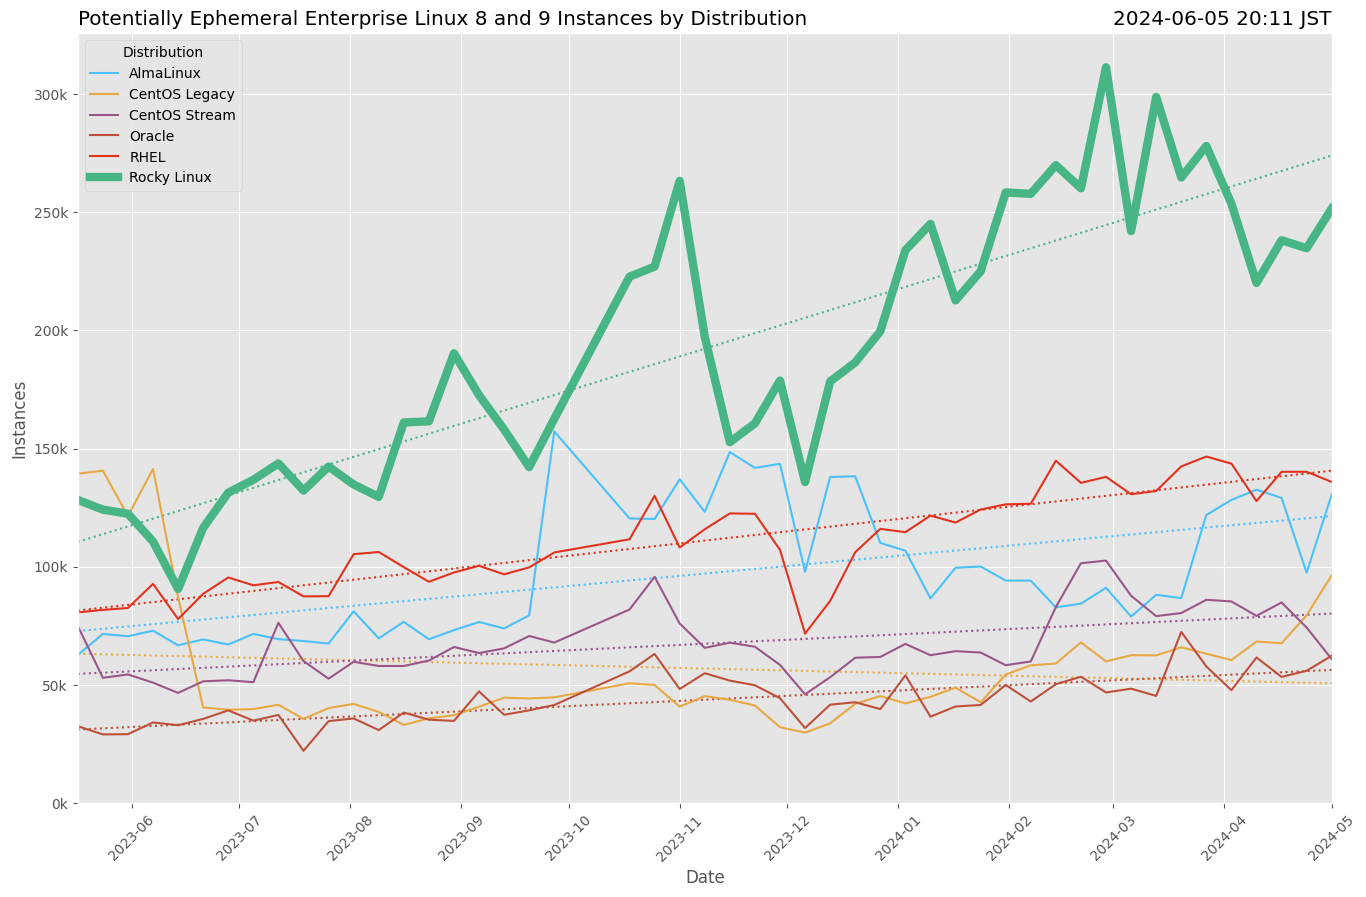

In [51]:
# Potentially Ephemeral Enterprise Linux Instances by Distribution
df = epel_dataframe
df = df[(df['repo_tag'].isin(['epel-8', 'epel-9'])) & (df['sys_age'] == 1) & (df['week_end'] > startdate)]
pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_name', fill_value=0, aggfunc=np.sum)

plt.style.use(plotstyle)
fig = plt.figure(figsize=(figx, figy))
ax = fig.add_subplot()

for distro in distros:
  x = mdates.date2num(pt.index)
  z = np.polyfit(x, pt[distro], 1)
  p = np.poly1d(z)
  xx = np.linspace(x.min(), x.max(), 100)
  dd = mdates.num2date(xx)
  ax.plot(dd, p(xx), ':', color=colors[distro])
    
for distro in distros:
  if distro == emphasize:
    ax.plot(pt[distro], label=labels[distro], color=colors[distro], linewidth=6)
  else:
    ax.plot(pt[distro], label=labels[distro], color=colors[distro])
    
xmajorrule = mdates.RRuleLocator(mdates.rrulewrapper(mdates.MONTHLY))
ax.xaxis.set_major_locator(xmajorrule)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands))
ax.set_ylim(bottom=0)
plt.title('Potentially Ephemeral Enterprise Linux 8 and 9 Instances by Distribution', loc='left')
plt.title(datetime.now().astimezone().strftime("%Y-%m-%d %H:%M %Z"), loc='right')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Instances')
plt.legend(loc='upper left', title='Distribution')
plt.margins(0, tight=True)
plt.savefig(workdir + 'el_by_distro_ephemeral_line.png', bbox_inches='tight')
plt.savefig(workdir + 'el_by_distro_ephemeral_line.svg', bbox_inches='tight')

/var/folders/54/zdqwn78j1cn7yvymyvv75shw0000gn/T/ipykernel_4132/1704073553.py:4: FutureWarning: The provided callable <function sum at 0x10409cd60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_name', aggfunc=np.sum)


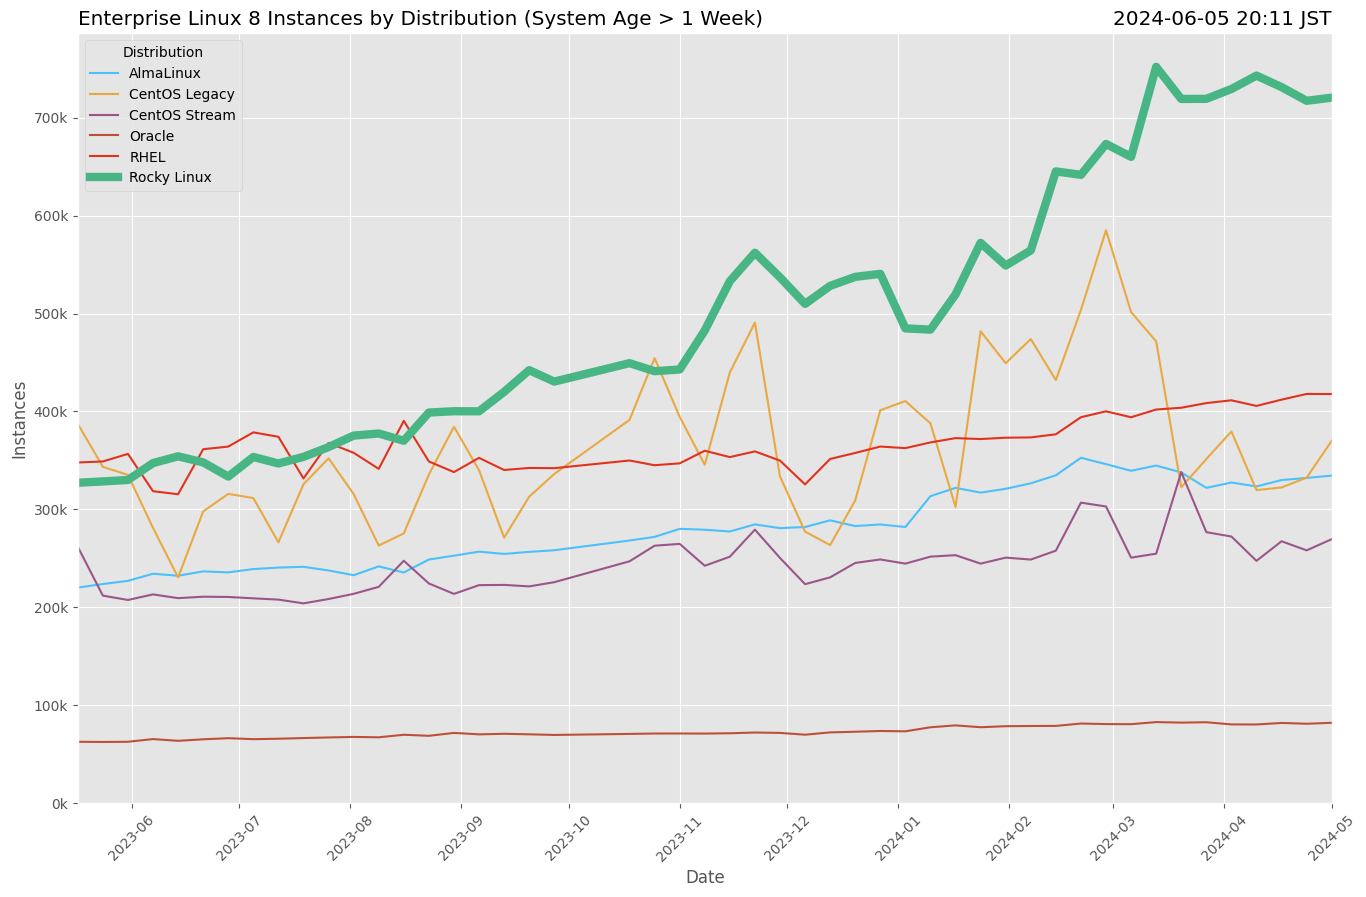

In [52]:
# Enterprise Linux 8 Instances by Distribution
df = epel_dataframe
df = df[(df['repo_tag'] == 'epel-8') & (df['sys_age'] > 1) & (df['week_end'] > startdate)]
pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_name', aggfunc=np.sum)

plt.style.use(plotstyle)
fig = plt.figure(figsize=(figx, figy))
ax = fig.add_subplot()

for distro in distros:
  if distro == 'Rocky Linux':
    ax.plot(pt[distro], label=labels[distro], color=colors[distro], linewidth=6)
  else:
    ax.plot(pt[distro], label=labels[distro], color=colors[distro])

xmajorrule = mdates.RRuleLocator(mdates.rrulewrapper(mdates.MONTHLY))
ax.xaxis.set_major_locator(xmajorrule)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands))
ax.set_ylim(bottom=0)
plt.title('Enterprise Linux 8 Instances by Distribution (System Age > 1 Week)', loc='left')
plt.title(datetime.now().astimezone().strftime("%Y-%m-%d %H:%M %Z"), loc='right')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Instances')
plt.legend(title='Distribution')
plt.margins(0, tight=True)
plt.savefig(workdir + 'el8_by_distro_line.png', bbox_inches='tight')
plt.savefig(workdir + 'el8_by_distro_line.svg', bbox_inches='tight')

/var/folders/54/zdqwn78j1cn7yvymyvv75shw0000gn/T/ipykernel_4132/762120764.py:4: FutureWarning: The provided callable <function sum at 0x10409cd60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_name', aggfunc=np.sum)


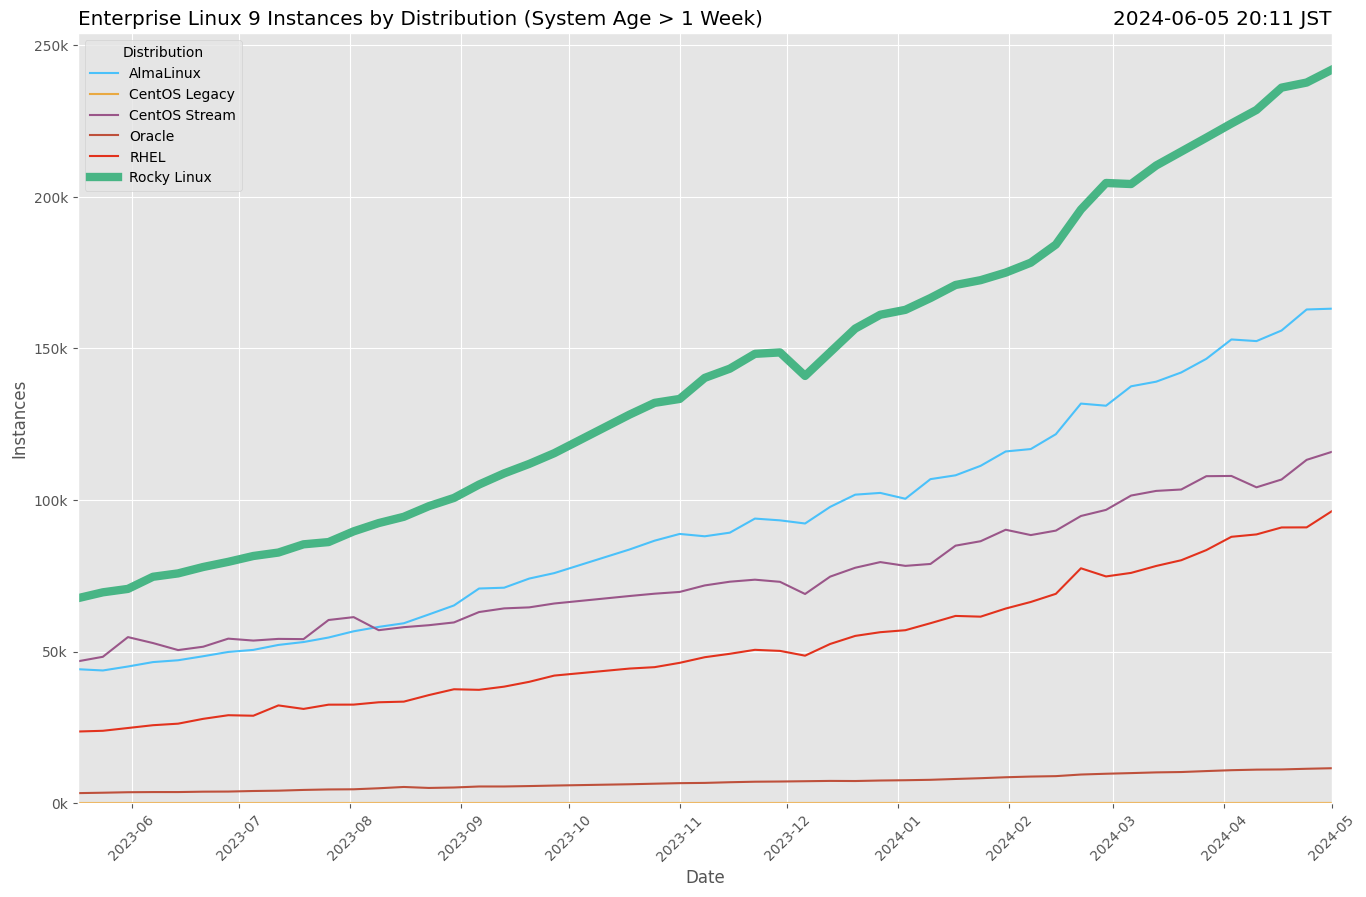

In [53]:
# Enterprise Linux 9 Instances by Distribution
df = epel_dataframe
df = df[(df['repo_tag'] == 'epel-9') & (df['sys_age'] > 1) & (df['week_end'] > startdate)]
pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_name', aggfunc=np.sum)

plt.style.use(plotstyle)
fig = plt.figure(figsize=(figx, figy))
ax = fig.add_subplot()

for distro in distros:
  if distro == emphasize:
    ax.plot(pt[distro], label=labels[distro], color=colors[distro], linewidth=6)
  else:
    ax.plot(pt[distro], label=labels[distro], color=colors[distro])

xmajorrule = mdates.RRuleLocator(mdates.rrulewrapper(mdates.MONTHLY))
ax.xaxis.set_major_locator(xmajorrule)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands))
ax.set_ylim(bottom=0)
plt.title('Enterprise Linux 9 Instances by Distribution (System Age > 1 Week)', loc='left')
plt.title(datetime.now().astimezone().strftime("%Y-%m-%d %H:%M %Z"), loc='right')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Instances')
plt.legend(title='Distribution')
plt.margins(0, tight=True)
plt.savefig(workdir + 'el9_by_distro_line.png', bbox_inches='tight')
plt.savefig(workdir + 'el9_by_distro_line.svg', bbox_inches='tight')

/var/folders/54/zdqwn78j1cn7yvymyvv75shw0000gn/T/ipykernel_4132/3273010956.py:4: FutureWarning: The provided callable <function sum at 0x10409cd60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pt = pd.pivot_table(df, values='hits', index='week_end', columns='repo_arch', fill_value=0, aggfunc=np.sum)


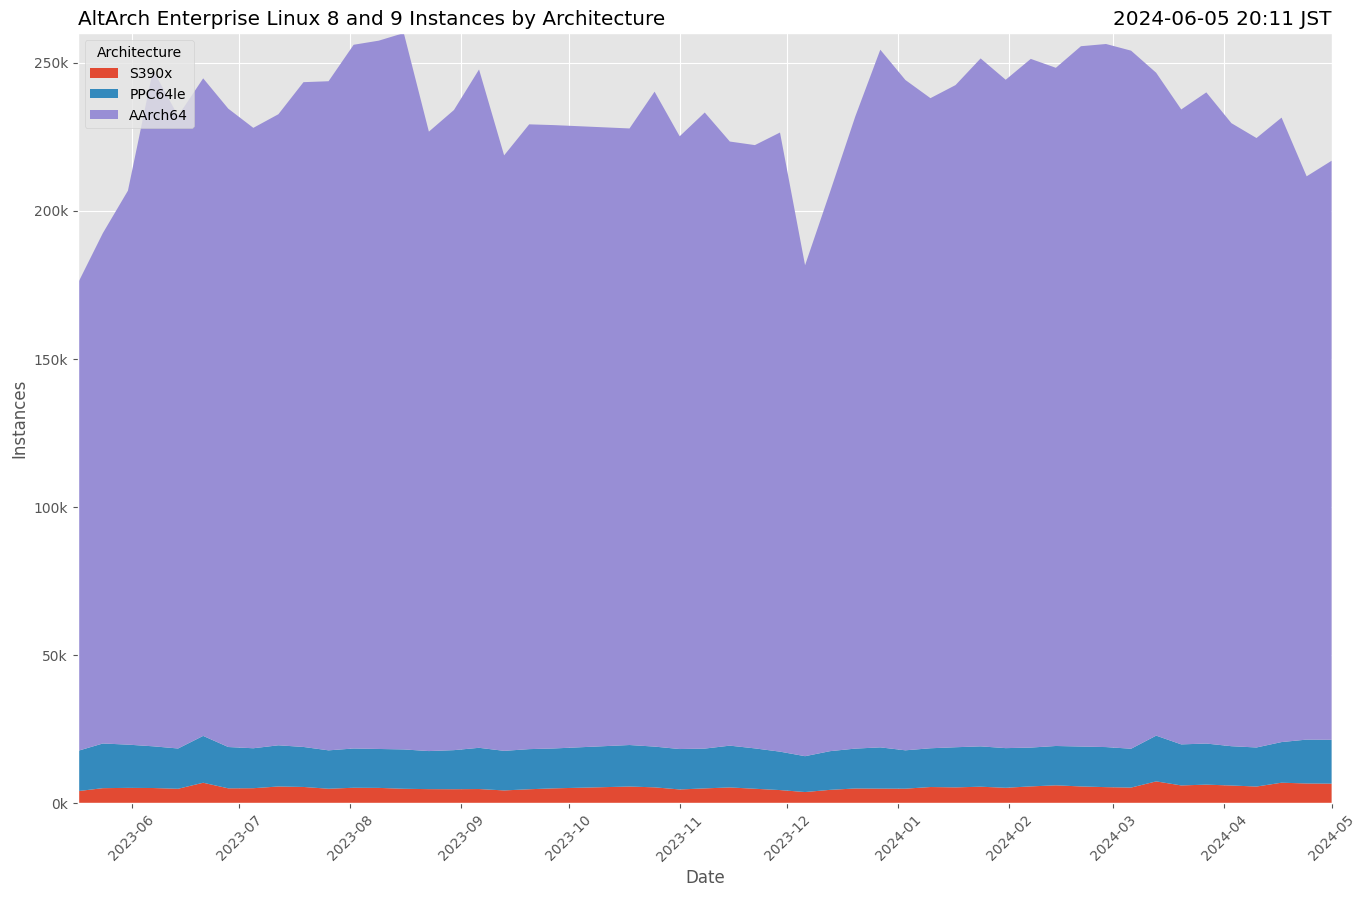

In [54]:
# AltArch Enterprise Linux Instances by Architecture
df = epel_dataframe
df = df[(df['repo_tag'].isin(['epel-8', 'epel-9'])) & (df['repo_arch'] != 'x86_64') & (df['week_end'] > startdate)]
pt = pd.pivot_table(df, values='hits', index='week_end', columns='repo_arch', fill_value=0, aggfunc=np.sum)

plt.style.use(plotstyle)
fig = plt.figure(figsize=(figx, figy))
ax = fig.add_subplot()
ax.stackplot(pt.index, pt['s390x'], pt['ppc64le'], pt['aarch64'], labels=['S390x', 'PPC64le', 'AArch64'])
xmajorrule = mdates.RRuleLocator(mdates.rrulewrapper(mdates.MONTHLY))
ax.xaxis.set_major_locator(xmajorrule)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands))
plt.title('AltArch Enterprise Linux 8 and 9 Instances by Architecture', loc='left')
plt.title(datetime.now().astimezone().strftime("%Y-%m-%d %H:%M %Z"), loc='right')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Instances')
# plt.yticks(np.arange(0, 500001, step=50000))
plt.legend(title='Architecture', loc='upper left')
plt.margins(0, tight=True)
plt.savefig(workdir + 'altarch_by_arch_area.png', bbox_inches='tight')
plt.savefig(workdir + 'altarch_by_arch_area.svg', bbox_inches='tight')

/var/folders/54/zdqwn78j1cn7yvymyvv75shw0000gn/T/ipykernel_4132/3561545674.py:5: FutureWarning: The provided callable <function sum at 0x10409cd60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pt = pd.pivot_table(df, values='hits', index='week_end', columns='sys_age', fill_value=0, aggfunc=np.sum)


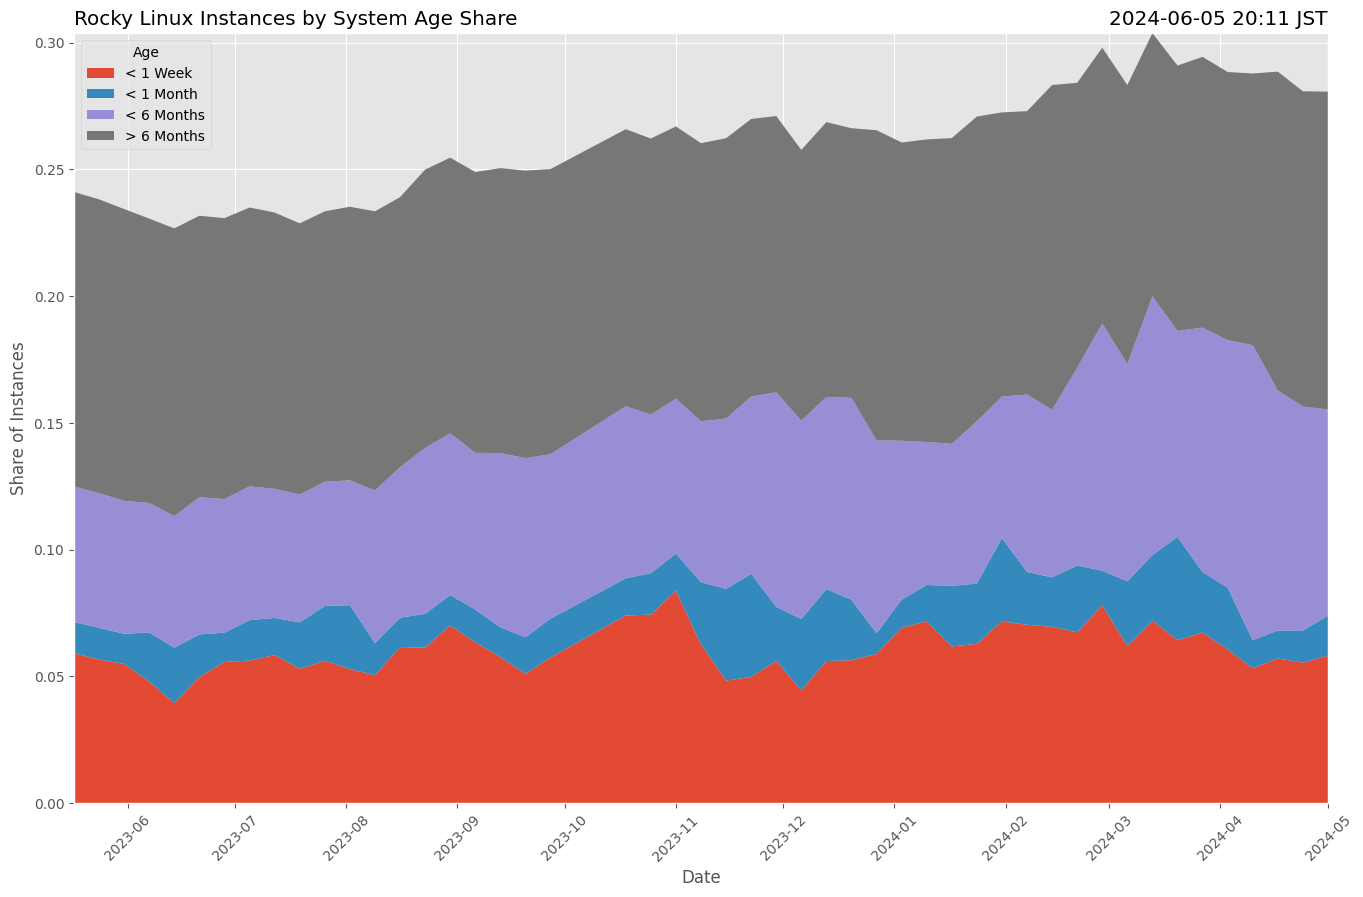

In [55]:
# Rocky Linux Instances by System Age Share

df = epel_dataframe
df = df[(df['repo_tag'].isin(['epel-8', 'epel-9'])) & (df['week_end'] > startdate) & (df['os_name'] == 'Rocky Linux')]
pt = pd.pivot_table(df, values='hits', index='week_end', columns='sys_age', fill_value=0, aggfunc=np.sum)

pt['total'] = pt.sum(numeric_only = True, axis = 1)

plt.style.use(plotstyle)
fig = plt.figure(figsize=(figx, figy))
ax = fig.add_subplot()
ax.stackplot(pt.index, pt[1]/pt['total'], pt[2]/pt['total'], pt[3]/pt['total'], pt[4]/pt['total'], labels=['< 1 Week', '< 1 Month', '< 6 Months', '> 6 Months'])

ax.xaxis.set_major_locator(mdates.RRuleLocator(mdates.rrulewrapper(mdates.MONTHLY)))

plt.title('Rocky Linux Instances by System Age Share', loc='left')
plt.title(datetime.now().astimezone().strftime("%Y-%m-%d %H:%M %Z"), loc='right')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Share of Instances')
# plt.yticks(np.arange(0, 500001, step=50000))
plt.legend(title='Age', loc='upper left')
plt.margins(0, tight=True)
plt.savefig(workdir + 'rocky_by_age_share_area.png', bbox_inches='tight')
plt.savefig(workdir + 'rocky_by_age_share_area.svg', bbox_inches='tight')

/var/folders/54/zdqwn78j1cn7yvymyvv75shw0000gn/T/ipykernel_4132/3121362100.py:5: FutureWarning: The provided callable <function sum at 0x10409cd60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pt = pd.pivot_table(df, values='hits', index='sys_age', columns='os_name', fill_value=0, aggfunc=np.sum)


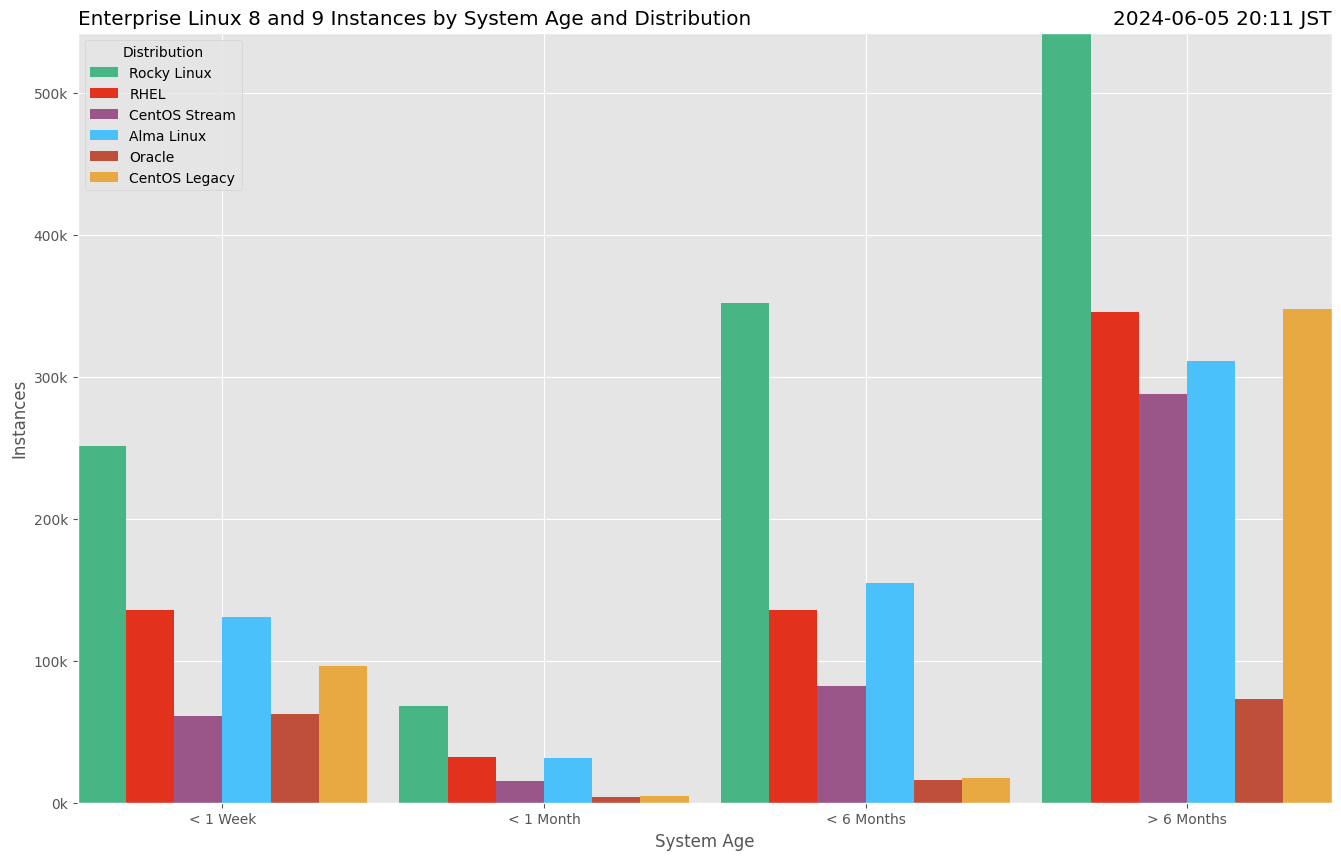

In [56]:
# Enterprise Linux Instances by System Age and Distribution

df = epel_dataframe
df = df[(df['week_end'] == max(df['week_end'])) & (df['sys_age'] > 0) & (df['repo_tag'].isin(['epel-8', 'epel-9']))]
pt = pd.pivot_table(df, values='hits', index='sys_age', columns='os_name', fill_value=0, aggfunc=np.sum)

plt.style.use(plotstyle)
fig = plt.figure(figsize=(figx, figy))
ax = fig.add_subplot()

x = np.arange(len(pt.index))
width = 0.15

ax.bar(x - 5*(width/2), pt['Rocky Linux'], width, label='Rocky Linux', color='#48B585')
ax.bar(x - 3*(width/2), pt['Red Hat Enterprise Linux'], width, label='RHEL', color='#E2321D')
ax.bar(x - 1*(width/2), pt['CentOS Stream'], width, label='CentOS Stream', color='#9A5689')
ax.bar(x + 1*(width/2), pt['AlmaLinux'], width, label='Alma Linux', color='#4AC1FA')
ax.bar(x + 3*(width/2), pt['Oracle Linux Server'], width, label='Oracle', color='#BE503B')
ax.bar(x + 5*(width/2), pt['CentOS Linux'], width, label='CentOS Legacy', color='#E9A942')
ax.set_xticks(x, ['< 1 Week', '< 1 Month', '< 6 Months', '> 6 Months'])

ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands))

plt.title('Enterprise Linux 8 and 9 Instances by System Age and Distribution', loc='left')
plt.title(datetime.now().astimezone().strftime("%Y-%m-%d %H:%M %Z"), loc='right')
plt.xlabel('System Age')
plt.ylabel('Instances')
plt.legend(title='Distribution', loc='upper left')
plt.margins(0, tight=True)
plt.savefig(workdir + 'el_by_age_distro_bars.png', bbox_inches='tight')
plt.savefig(workdir + 'el_by_age_distro_bars.svg', bbox_inches='tight')

/var/folders/54/zdqwn78j1cn7yvymyvv75shw0000gn/T/ipykernel_4132/1874439699.py:5: FutureWarning: The provided callable <function sum at 0x10409cd60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_version', fill_value=0, aggfunc=np.sum)


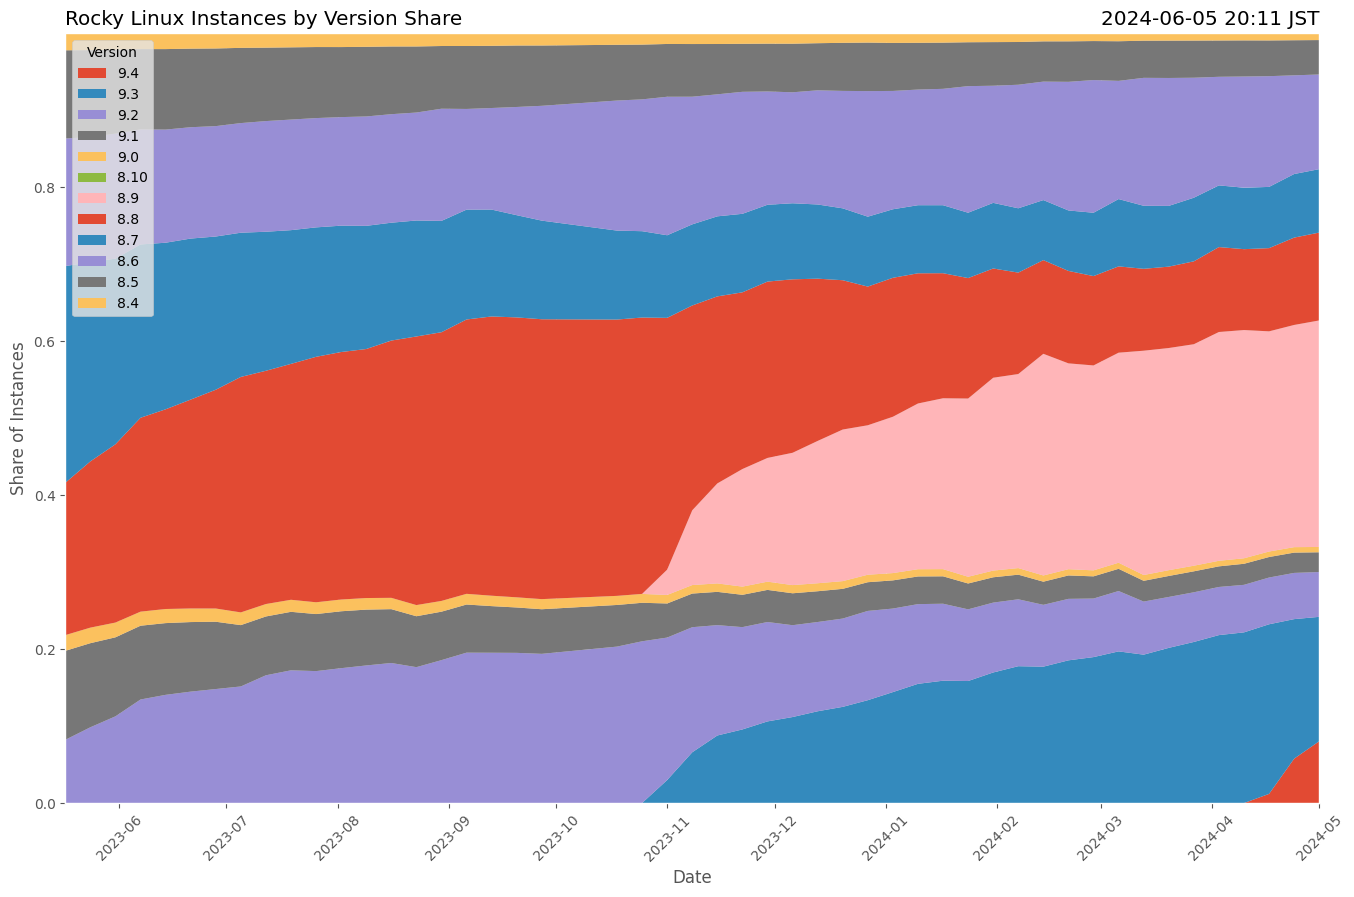

In [57]:
# Rocky Linux Instances by Version Share

df = epel_dataframe
df = df[(df['repo_tag'].isin(['epel-8', 'epel-9'])) & (df['os_name'] == 'Rocky Linux') & (df['week_end'] > startdate)]
pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_version', fill_value=0, aggfunc=np.sum)

pt['total'] = pt.sum(numeric_only = True, axis = 1)

plt.style.use(plotstyle)
fig = plt.figure(figsize=(figx, figy))
ax = fig.add_subplot()
ax.stackplot(pt.index, pt['9.4']/pt['total'], pt['9.3']/pt['total'], pt['9.2']/pt['total'], pt['9.1']/pt['total'], pt['9.0']/pt['total'], pt['8.10']/pt['total'], pt['8.9']/pt['total'], pt['8.8']/pt['total'], pt['8.7']/pt['total'], pt['8.6']/pt['total'], pt['8.5']/pt['total'], pt['8.4']/pt['total'], \
             labels=['9.4', '9.3', '9.2', '9.1', '9.0', '8.10', '8.9', '8.8', '8.7', '8.6', '8.5', '8.4'])

ax.xaxis.set_major_locator(mdates.RRuleLocator(mdates.rrulewrapper(mdates.MONTHLY)))

plt.title('Rocky Linux Instances by Version Share', loc='left')
plt.title(datetime.now().astimezone().strftime("%Y-%m-%d %H:%M %Z"), loc='right')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Share of Instances')
plt.legend(loc='upper left', title='Version')
plt.margins(0, tight=True)
plt.savefig(workdir + 'rocky_by_version_share_area.png', bbox_inches='tight')
plt.savefig(workdir + 'rocky_by_version_share_area.svg', bbox_inches='tight')

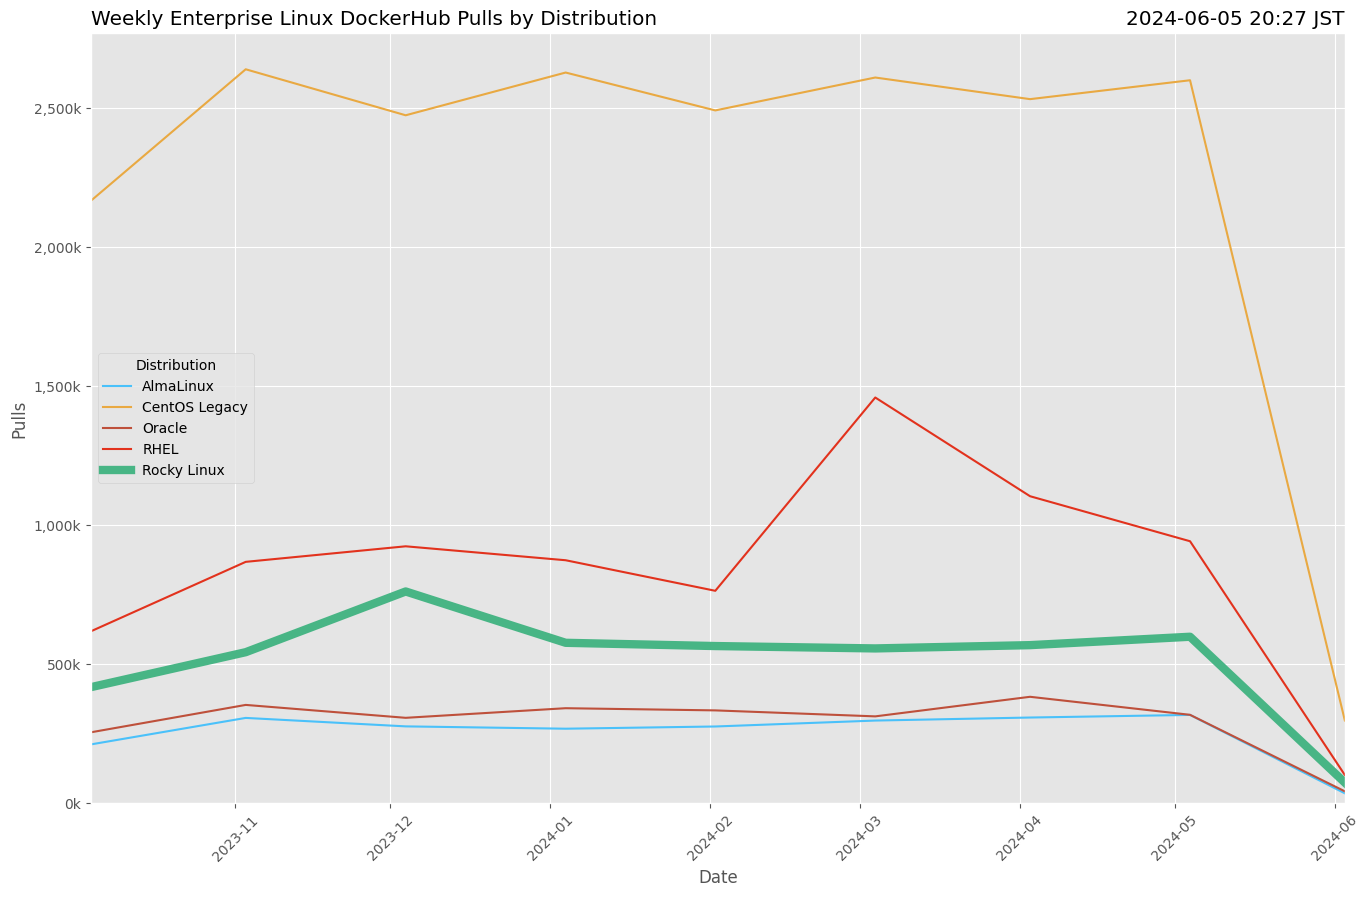

In [66]:
# Enterprise Linux DockerHub Pulls
df = dh_dataframe
df = df[df.index > "2023-10-09"]

df = df.resample('ME').sum()

plt.style.use(plotstyle)
fig = plt.figure(figsize=(figx, figy))
ax = fig.add_subplot()

for distro in dh_distros:
  if distro == emphasize:
    ax.plot(df[distro], label=labels[distro], color=colors[distro], linewidth=6)
  else:
    ax.plot(df[distro], label=labels[distro], color=colors[distro])
      
ax.xaxis.set_major_locator(mdates.RRuleLocator(mdates.rrulewrapper(mdates.MONTHLY)))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands))

ax.set_ylim(bottom=0)
plt.title('Weekly Enterprise Linux DockerHub Pulls by Distribution', loc='left')
plt.title(datetime.now().astimezone().strftime("%Y-%m-%d %H:%M %Z"), loc='right')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Pulls')
plt.legend(title='Distribution')
plt.margins(0, tight=True)
plt.savefig(workdir + 'dh_by_distro_line.png', bbox_inches='tight')
plt.savefig(workdir + 'dh_by_distro_line.svg', bbox_inches='tight')